In [4]:
# Author: Hassan Ismail Fawaz <hassan.ismail-fawaz@uha.fr>
#         Germain Forestier <germain.forestier@uha.fr>
#         Jonathan Weber <jonathan.weber@uha.fr>
#         Lhassane Idoumghar <lhassane.idoumghar@uha.fr>
#         Pierre-Alain Muller <pierre-alain.muller@uha.fr>
# License: GPL3

import numpy as np
import pandas as pd
import matplotlib

#matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=5, highv=15,
                width=100, textspace=1, reverse=True, filename=None, labels=False, dpi=10, dontplot=[],**kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height),dpi=dpi)
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 0.5
    linewidth_sign = 2.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        current_name = filter_names(nnames[i])
        chei = cline + minnotsignificant + i * space_between_names
        if not current_name in dontplot:
            line([(rankpos(ssums[i]), cline),
                  (rankpos(ssums[i]), chei),
                  (textspace - 0.1, chei)],
                 linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.2f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        current_name = filter_names(nnames[i])
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        if not current_name in dontplot:
            line([(rankpos(ssums[i]), cline),
                  (rankpos(ssums[i]), chei),
                  (textspace + scalewidth + 0.1, chei)],
                 linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.2f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = 0
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    #print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        #print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign,color='r')
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=30, textspace=3, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.pdf',bbox_inches='tight')

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    #print(pd.unique(df_perf['classifier_name']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    #print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets

#df_perf = pd.read_csv('DefaultvsTunedvsEnsembleCritDiffAcc.csv',index_col=False)

#draw_cd_diagram(df_perf=df_perf, title='Accuracy', labels=True)

In [22]:
def convert_table(df,performance_measure,logscale=False):

    curve_models = df['curve_model'].unique()

    rows = []
    info_rows = []
    for (openmlid, df_dataset) in tqdm(df.groupby('openmlid')):
        for (learner, df_learner) in df_dataset.groupby('learner'):
            for (n, df_n) in df_learner.groupby('n'):
                new_row = []
                bucket = df_n.iloc[0,:].percentage_bucket
                info_rows.append([openmlid,learner,n,bucket])
                for curve_model in curve_models:
                    row = df_n.query('curve_model == @curve_model')
                    score = np.nan
                    if len(row) > 0:
                        row = row.iloc[0,:]
                        score = row[performance_measure]
                    new_row.append(score)
                rows.append(new_row)

    a = np.array(rows)
    if logscale == True:
        a = np.log(a)
    a = pd.DataFrame(a,columns=curve_models)
    a_info = np.array(info_rows)
    a_info = pd.DataFrame(a_info,columns=['openmlid','learner','n','bucket'])
    b = pd.concat([a_info,a],axis=1)
    return b

def remove_rows_with_nan_or_inf(c):
    c = c.copy()
    ind_nan_or_inf = c.isin([np.inf, -np.inf, np.nan]).any(axis=1)
    c = c[ind_nan_or_inf == False]
    return c

In [3]:
from os.path import exists
import pandas as pd


if exists('temp3/table_MSE_tst_last.p'):
    table_MSE_tst_last = pd.read_pickle('temp3/table_MSE_tst_last.p')
else:
    table_MSE_tst_last = convert_table(df_clean_buckets,'MSE_tst_last')
    table_MSE_tst_last.to_pickle('table_MSE_tst_last.p')

if exists('temp3/table_MSE_tst.p'):
    table_MSE_tst = pd.read_pickle('temp3/table_MSE_tst.p')
else:
    table_MSE_tst = convert_table(df_clean_buckets,'MSE_tst')
    table_MSE_tst.to_pickle('table_MSE_tst.p')

if exists('temp3/table_MSE_trn.p'):
    table_MSE_trn = pd.read_pickle('temp3/table_MSE_trn.p')
else:
    table_MSE_trn = convert_table(df_clean_buckets,'MSE_trn')
    table_MSE_trn.to_pickle('table_MSE_trn.p')


In [21]:
curve_models = table_MSE_tst_last.columns[4:]


14.733631580968472

In [27]:
p_values, average_ranks, _ = wilcoxon_holm(df_perf=table_MSE_tst_last_all, alpha=0.05)


[('exp2', 'exp3', 0.0, True),
 ('exp2', 'exp4', 0.0, True),
 ('exp2', 'expd3', 0.0, True),
 ('exp2', 'expp3', 0.0, True),
 ('exp2', 'ilog2', 0.0, True),
 ('exp2', 'last1', 0.0, True),
 ('exp2', 'lin2', 0.0, True),
 ('exp2', 'log2', 0.0, True),
 ('exp2', 'logpower3', 0.0, True),
 ('exp2', 'mmf4', 0.0, True),
 ('exp2', 'pow2', 0.0, True),
 ('exp2', 'pow3', 0.0, True),
 ('exp2', 'pow4', 0.0, True),
 ('exp2', 'vap3', 0.0, True),
 ('exp2', 'wbl4', 0.0, True),
 ('exp3', 'exp4', 0.0, True),
 ('exp3', 'expd3', 0.0, True),
 ('exp3', 'expp3', 0.0, True),
 ('exp3', 'ilog2', 0.0, True),
 ('exp3', 'last1', 0.0, True),
 ('exp3', 'lin2', 0.0, True),
 ('exp3', 'logpower3', 0.0, True),
 ('exp3', 'mmf4', 0.0, True),
 ('exp3', 'pow3', 0.0, True),
 ('exp3', 'pow4', 0.0, True),
 ('exp3', 'vap3', 0.0, True),
 ('exp3', 'wbl4', 0.0, True),
 ('exp4', 'expd3', 0.0, True),
 ('exp4', 'expp3', 0.0, True),
 ('exp4', 'lin2', 0.0, True),
 ('exp4', 'log2', 0.0, True),
 ('exp4', 'mmf4', 0.0, True),
 ('exp4', 'pow2', 0.

In [46]:
dontplot = []
for method in average_ranks.keys():
    rank = average_ranks[method]
    if rank > highv:
        dontplot.append(method)
    if rank < lowv:
        dontplot.append(method)

In [57]:
lowv, highv, dontplot = determine_plotting(p_values,average_ranks)
lowv

6

In [55]:
def determine_plotting(p_values,average_ranks):

    methods = []
    for p in p_values:
        if p[3] == False:
            methods.append(p[0])
            methods.append(p[1])
    methods = np.unique(np.array(methods))

    visible = []
    for m in methods:
        visible.append(average_ranks[m])

    visible = np.array(visible)
    lowv = np.floor(np.min(visible))
    highv = np.ceil(np.max(visible))

    dontplot = []
    for method in average_ranks.keys():
        rank = average_ranks[method]
        if rank > highv:
            dontplot.append(method)
        if rank < lowv:
            dontplot.append(method)

    return int(lowv), int(highv), dontplot

In [58]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')




def prepare_data_for_cd(b):
    
    c = remove_rows_with_nan_or_inf(b)

    melted = pd.melt(c,id_vars=['openmlid','learner','n'],value_vars=curve_models)
    dataset_name = melted.agg('{0[openmlid]},{0[learner]},{0[n]}'.format, axis=1)
    melted['dataset_name'] = dataset_name

    df_cd = melted[['variable','dataset_name','value']]
    df_cd = df_cd.rename(columns={'variable': 'classifier_name', 'value': 'accuracy'})
    df_cd['accuracy'] = -df_cd['accuracy']
    return df_cd

def cd_plot(df_cd,lowv=1,highv=16,dontplot=[],title=None,auto=True):
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_cd, alpha=0.05)
    
    if auto:
        lowv, highv, dontplot = determine_plotting(p_values,average_ranks)
    
    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=8, textspace=0, labels=True, dpi=600,lowv=lowv,highv=highv,dontplot=dontplot)
    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    return lowv, highv, dontplot

C:\Users\tjviering\AppData\Local\Temp\ipykernel_4460\1978462567.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [23]:
table_MSE_tst_last_all = prepare_data_for_cd(table_MSE_tst_last)
table_MSE_tst_all = prepare_data_for_cd(table_MSE_tst)
table_MSE_trn_all = prepare_data_for_cd(table_MSE_trn)


In [25]:
table_MSE_tst_last_005 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.05"'))
#table_MSE_tst_last_010 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.1"'))
table_MSE_tst_last_020 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.2"'))
table_MSE_tst_last_040 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.4"'))
table_MSE_tst_last_080 = prepare_data_for_cd(table_MSE_tst_last.query('bucket=="0.8"'))

table_MSE_tst_005 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.05"'))
#table_MSE_tst_010 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.1"'))
table_MSE_tst_020 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.2"'))
table_MSE_tst_040 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.4"'))
table_MSE_tst_080 = prepare_data_for_cd(table_MSE_tst.query('bucket=="0.8"'))

table_MSE_trn_005 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.05"'))
#table_MSE_trn_010 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.10"'))
table_MSE_trn_020 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.2"'))
table_MSE_trn_040 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.4"'))
table_MSE_trn_080 = prepare_data_for_cd(table_MSE_trn.query('bucket=="0.8"'))

In [68]:
plots = []
plots.append((table_MSE_tst_last_all,'ranking MSE test last','MSE_tst_last.pdf'))
plots.append((table_MSE_tst_last_005,'ranking MSE test last <5%','MSE_tst_last_005.pdf'))
#plots.append((table_MSE_tst_last_010,'ranking MSE test last 5%-10%','MSE_tst_010.png'))
plots.append((table_MSE_tst_last_020,'ranking MSE test last 10%-20%','MSE_tst_last_020.pdf'))
plots.append((table_MSE_tst_last_040,'ranking MSE test last 20%-40%','MSE_tst_last_040.pdf'))
plots.append((table_MSE_tst_last_080,'ranking MSE test last 40%-80%','MSE_tst_last_080.pdf'))

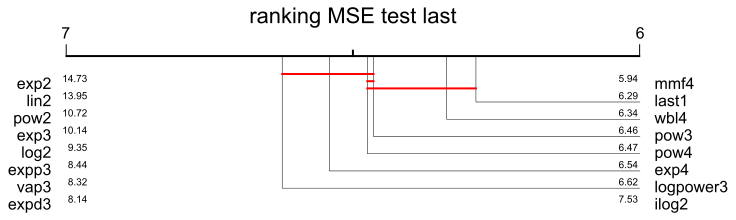

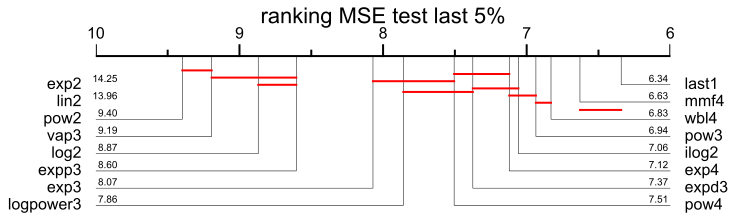

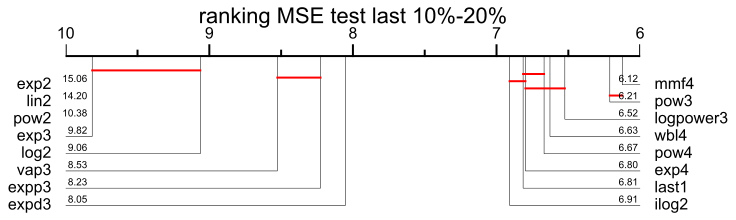

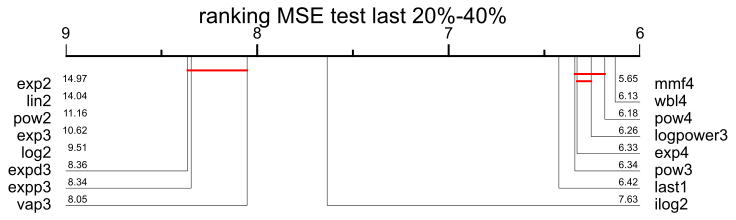

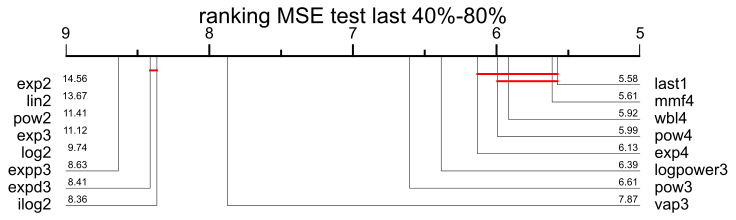

In [70]:
for p in plots:
    table = p[0]
    title = p[1]
    fn = p[2]

    cd_plot(table,title=title)
    plt.savefig(fn,bbox_inches='tight')